In [296]:
%matplotlib inline
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from astropy.io import fits
from scipy import interpolate
import multiprocessing
import statsmodels.api as sm
from scipy.special import eval_legendre, eval_chebys
from numpy.linalg import inv

In [297]:
SPECTRA_DIR = '/Volumes/PARKER/boss_files/new_sky_flux/'
spectra_files = glob.glob(SPECTRA_DIR+'*calibrated_sky.npy')
SAVE_DIR ='/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/split_flux/'

In [298]:
MetaData = np.load('/Volumes/PARKER/boss_files/new_sky_flux/meta_raw.npy')

## 1) Airglow Lines 

In [299]:
AIRGLOW_DIR = '/Users/parkerf/Research/SkyModel/SkyModelling/AirglowSpectra/cosby'
AirglowFiles = glob.glob(AIRGLOW_DIR+'/*.txt')
AirglowLines = []
for file in AirglowFiles:
    data = pd.read_csv(file,delim_whitespace=True)
    d = data.to_records(index=False)
    AirglowLines.append(np.array(d))
AirglowLines = np.hstack(AirglowLines)

In [300]:
def air_to_vac(wave):
    """Index of refraction to go from wavelength in air to wavelength in vacuum
    Equation from (Edlen 1966)
    vac_wave = n*air_wave
    """
    #Convert to um
    wave_um = wave*.001
    ohm2 = (1./wave_um)**(2)

    #Calculate index at every wavelength
    nn = []
    for x in ohm2:
        n = 1+10**(-8)*(8342.13 + (2406030/float(130.-x)) + (15997/float(389-x)))
        nn.append(n)
    
    #Get new wavelength by multiplying by index of refraction
    vac_wave = nn*wave
    return vac_wave

In [301]:
#Get Vac Lines
b_sig = np.where(AirglowLines['obs_eint'] > 5)
bVL = air_to_vac(AirglowLines['obs_wave'])
bVL = bVL[b_sig] #nm to A
Hg = air_to_vac(np.asarray([404.6,435.8,546.0],dtype=float))

#print(Hg)
bVL = np.hstack([bVL, Hg])
BlueVacLines = bVL[bVL < 650]
#print(BlueVacLines)
print('blue: ',len(BlueVacLines))

r_sig = np.where(AirglowLines['obs_eint'] > 5)
rVL = air_to_vac(AirglowLines['obs_wave'])
rVL = rVL[r_sig] #nm to A
RedVacLines = rVL[rVL > 560]
print('red: ', len(RedVacLines))

blue:  38
red:  1087


In [24]:
BlueAirglowLines = np.load('blue_airglowlines.npy')

## 2) Get the Data and Perform analysis

In [302]:
ttype = 'blue'

In [305]:
%%time
for spectra_file in np.array(spectra_files):
    plate_num = spectra_file[-23:-19]
    print("Fitting spectra in plate %s" % plate_num)
    this_plate = MetaData[MetaData['PLATE'] == int(plate_num)]
    spectra = np.load(spectra_file) 
    
    specnos = get_specnos()
    spectra_length = len(specnos)
    print(spectra_length)

    Data = []
    for specno in specnos:
        Data.append(fit_and_split_spectrum(specno))

    np.save(SAVE_DIR+plate_num+'_split_fit',Data)

Fitting spectra in plate 3590
736
Fitting spectra in plate 3755
640
Fitting spectra in plate 4204
588


/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in double_scalars


Fitting spectra in plate 4865
400
Fitting spectra in plate 5339
1806
Fitting spectra in plate 5399
640
Fitting spectra in plate 5956
560
Fitting spectra in plate 6112
440
Fitting spectra in plate 6709
320
Fitting spectra in plate 7114
364
Fitting spectra in plate 7381
320
CPU times: user 4min, sys: 15.8 s, total: 4min 16s
Wall time: 4min 41s


In [124]:
def get_specnos():
    """Function that runs the linear model and saves the output. The output file is a .npy file that includes
    the parts of the model (lines, continuum, and residuals) along with the wavelengths associated for ease in comparison.
    It also contains some meta data so that these linear models can be correlated with the actual flux.

    This funciton is used in a multiprocessing loop.
    """

    if ttype == 'test':
        max_num = 10 
        specnos = this_plate[0: max_num]['SPECNO']
    elif ttype == 'blue':
        max_num = len(spectra)-1
        specnos = this_plate[(this_plate['CAMERAS'] == b'b1') | (this_plate['CAMERAS'] == b'b2')]['SPECNO']
    elif ttype == 'red':
        max_num = len(spectra)-1
        specnos = this_plate[(this_plate['CAMERAS'] == b'r1') | (this_plate['CAMERAS'] == b'r2')]['SPECNO']
    elif ttype == 'full':
        max_num = len(spectra)
        specnos = this_plate['SPECNO']
    else: 
        print("not a valid type. Going to test")
        max_num = 10 #len(spectra) Number of spectra in a given plate that you want to run this for. Mostly for debugging
        specnos = np.random.choice(this_plate['SPECNO'], size=max_num)

    return specnos

In [202]:
def fit_and_split_spectrum(specno):
    #print('splitting spectra %d/%d for plate %s' % (specno, spectra_length, plate_num))
    
    this_obs = this_plate[this_plate['SPECNO'] == specno]

    if len(this_obs) > 1:
        this_obs = this_obs[0]
        print("This observation had more than one specno with that number")
    else:
        pass

    if (this_obs['CAMERAS'] == b'b1') | (this_obs['CAMERAS'] == b'b2'):
        model = linear_model(spectra[specno], 3, BlueVacLines,'OLS')
    elif (this_obs['CAMERAS'] == b'r1') | (this_obs['CAMERAS'] == b'r2'):
        model = linear_model(spectra[specno], 2, RedVacLines,'OLS')
    else:
        print("Don't recognize the camera")
        model = [0, 0, 0, 0, 0]

    model_fit = np.zeros(len(model[0]),dtype=[('PLATE','i4'), ('COLOR','S2'), ('SPECNO','i4'), ('WAVE','f8'),
                                              ('LINES','f8'), ('CONT','f8'), ('RESIDS','f8'), ('R','f8')])
    model_fit['PLATE'] = plate_num
    model_fit['COLOR'] = this_obs['CAMERAS']
    model_fit['SPECNO'] = specno
    model_fit['WAVE'] = model[0]
    model_fit['LINES'] = model[1]
    model_fit['CONT'] = model[2]
    model_fit['RESIDS'] = model[3]
    model_fit['R'] = model[4]

    return model_fit

In [112]:
def clean_spectra(spectrum):
    """Takes out all nan/inf so lstsq will run smoothly
    """
    ok = np.isfinite(spectrum['SKY'])

    wave = spectrum['WAVE'][ok]
    sky = spectrum['SKY'][ok]
    sigma = spectrum['SIGMA'][ok]
    disp = spectrum['DISP'][ok]
    
    return [wave,sky,sigma,disp]

In [199]:
def airglow_line_components(vaclines, wave_range, disp_range):
    """ Takes each Airglow line included in the analysis and creates a gaussian profile 
    of the line. 
    INPUT: - List of airglow lines wanted to model
           - Wavelength range of the spectra
           - Wavelength dispersion for the wavelength range of the spectra
    OUTPUT: 
           Matrix with all lines used for linear regression. Size[len(wave_range),len(airglow_lines)]
    """
    AA = []
    for line in vaclines:
        AA.append(np.exp(-0.5*((wave_range-line)/disp_range)**2))
    return np.vstack(AA)

In [187]:
blue_spectra['WAVE'] - BlueVacLines[0]

array([ -26.42478271,  -26.32495324,  -26.22511042, ...,  243.31391697,
        243.42636802,  243.53881897])

In [304]:
def linear_model(spectrum, num_cont, vaclines, mod):
    """ This is the heart of the program. It computes the linear model using Ordinary Least Squares. It then
    splits up the model into components: lines, continuum and residuals.
    The inputs characterize whether it is a blue or red sky fit. They have slightly different 
    continuum models and we break up the airglow lines so that it is faster.

    INPUTS:  - sky spectrum: from Boss Sky Spectra (generated by spframe_flux.py)
             - num_cont: the number of polynomials used for the continuum fitting
             - airglow_lines: the set of lines used to fit out the airglow. different for blue/red
    OUTPUTS: - wave_range: original wavelength range (generated by spframe_flux.py)
             - lines: Airglow lines fitted
             - cont: Continuum fitted
             - res: Residuals between linear model and original sky flux
             - R: R^2 value to determine goodness of fit
    """
    wave, sky, sigma, disp = clean_spectra(spectrum)
    AA = airglow_line_components(vaclines, wave, disp)

    # Continuum model
    AC = []
    for i in range(num_cont):
        AC.append(eval_legendre(i, wave))
        
    AC = np.array(AC)
    A = np.stack(np.vstack((AC, AA)), axis=1)

    new_sigma = sigma+0.02*sky
    #print(np.unique(new_sigma))

    if mod == 'LA':
        AAA = []
        for row in A.T:
            if np.all(row > 0, axis=0):
                AAA.append(row)
        AAA = np.array(AAA)
        X = np.dot(inv(np.dot(AAA,AAA.T)),np.dot(AAA.T,sky))
        model = np.dot(AAA,X)
    elif mod == 'LSQ':
        lsq = lstsq(A,sky)
        model = np.dot(A,lsq[0])
        params = lsq[0]
    elif mod == 'OLS':
        results = sm.OLS(sky, A).fit()
        params = results.params
        model = np.dot(A, params)
    elif mod == 'WLS':
        results = sm.WLS(sky, A, weights = sigma).fit()
        params = results.params
        model = np.dot(A, params)
    elif mod == 'newsigma':
        print("using new sigma)")
        results = sm.WLS(sky, A, weights = new_sigma).fit()
        params = results.params
        print(params)
        model = np.dot(A, params)
    else:
        print("Choose a correct model")

    #Separate
    cont = np.dot(A[:,0:num_cont], params[0:num_cont])
    lines = np.dot(A[:,num_cont:], params[num_cont:])
    res = sky - model

    #R^2
    R_1 = np.sum([(i)**2 for i in res])
    R_2 = np.sum([(i-np.mean(sky))**2 for i in sky])  
    R = 1-(R_1/R_2)   
    #print("R^2 value: %f" %R)

    model = model
    A = A
    params = params

    return [wave, lines, cont, res, R]

In [25]:
#VacLines available: BlueVacLines, BlueAirglowLines, RedVacLines

In [294]:
%time blue1 = linear_model(blue_spectra, 3, BlueVacLines,'OLS')

R^2 value: 0.727651
CPU times: user 34.6 ms, sys: 2.61 ms, total: 37.2 ms
Wall time: 34.9 ms


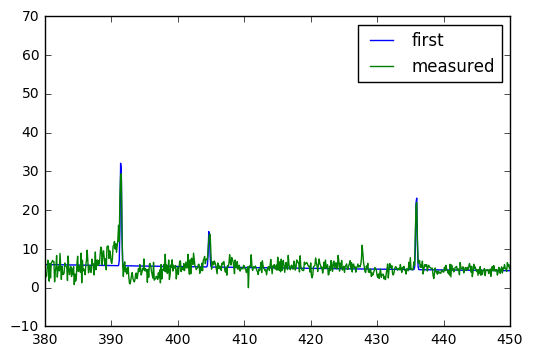

In [295]:
plt.plot(blue1[0], blue1[1]+blue1[2], label='first')
#plt.plot(blue1[0], blue_model2[0],label='second')
plt.plot(blue_spectra['WAVE'], blue_spectra['SKY'],label='measured')
#plt.xlim([555,560])
plt.xlim([380,450])
#plt.xlim([450,500])
#plt.xlim([500,550])
#plt.xlim([550,580])
#plt.xlim([580,600])
#plt.xlim([600,630])
plt.legend()

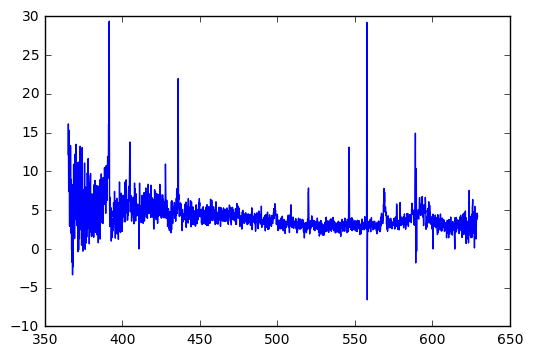

In [214]:
plt.plot(blue1[0],blue1[2]+blue1[3])

In [215]:
plt.plot(blue_wave, cont+res, label ='lsq')
plt.plot(blue_wave, cont2+res2, label = 'wls')
plt.legend()

NameError: name 'cont' is not defined

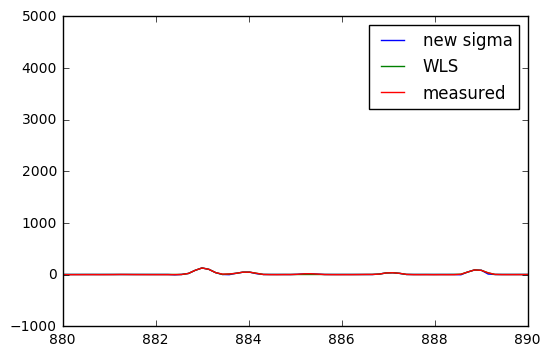

In [522]:
plt.plot(red_wave, red_model[0],label='new sigma')
plt.plot(red_wave, red_model2[0],label = 'WLS')
plt.plot(red_wave, red_sky, label='measured')
plt.xlim([880,890])
plt.legend()

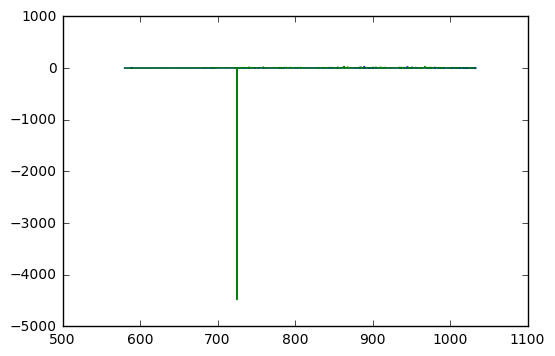

In [517]:
plt.plot(red_wave,cont+res)
plt.plot(red_wave,cont2+res2)
#plt.xlim([880,890])

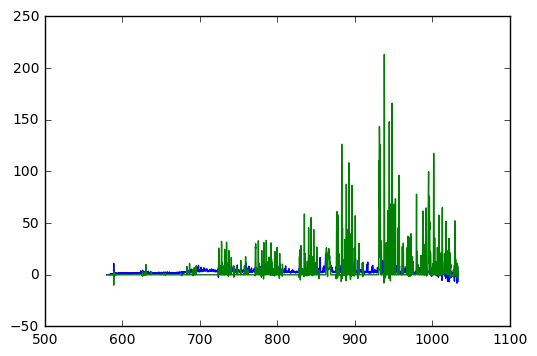

In [505]:
plt.plot(red_wave, cont+res, 'b-')
plt.plot(red_wave, lines, 'g-')